# Calorimeter regression task

In this project you will be looking at image like data from particle hits in a calorimeter. The goal of the project is to predict the location of the particle in the sky, using the data recorded by the calorimeter. Look in the `README.md` for more information.

First download the data, and then un-zip the data with `tar -zxvf data.tar.gz` into a data folder.
1. You can then use the functions within `utils.py` to load the data
2. We run `get_input_data` below to load in the images 

You may need to edit the `get_input_data` function in `utils.py` to have the right path.

## The training data
Here you get calorimeter images, as well as some additional information about the calorimeter.
The calorimeter data has the total energy of the corresponding image in the first column, and the calorimeter energy of the maximum bar.

## The target data
The target here is a vector of length four, where the first two columns are the x coordinates at the bottom and top, and then the y positions at the top and the bottom. To simplify the task, you can try predicting each layer individually, before attempting both layers together.
Top and bottom is relative to the tracker in the detector at -40mm and -200mm in z.


In [1]:
import os 
from utils import get_input_data
import numpy as np 
import helpers
import plotter 
from helpers import split_xy_intercept, order_xy_intercept, get_data_dict, sort_data_by_energy, split_dico, save_model, save_model_history, load_model_history
from plotter import plot_image, plot_model_history, plot_split_distribution, plot_energy
import matplotlib.pyplot as plt

# ML tools 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Input, losses, saving

from dampe_ai import split_train_val_test, calorimeter_model, std_compile, std_fit, std_compile_fit

import pdb

2024-06-16 18:39:40.504386: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 18:39:40.541708: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-16 18:39:40.542477: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-16 18:39:41.331682: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Usefull flags and hyperparameters
load_models = False
save_models = True
epochs      = 110

val_size  = 0.2
test_size = 0.5

Load all the data

In [3]:
calorimeter_images, calorimeter_data, data_target, benchmark_data = get_input_data()

In [4]:
# Normalize the data 
calorimeter_images = calorimeter_images / 255.0
# calorimeter_images = calorimeter_images.reshape(calorimeter_images.shape[:3])/ 255.0

#### Data structure:

`calorimeter_images`: Calorimeter images

`calorimeter_data`: Calorimeter 2 variables  - bgoene (CALO total energy), maxbar (CALO energy of maximum bar)

`data_target`: Truth/target 4 variables - normally variables that are targeted at the regression optimisation,
say x_bot, x_top, y_bot, y_top

`benchmark_data`: Benchmark predictions 4 variables - Obtained from the standard BGO rec direction, x_bot, x_top, y_bot, y_top 

In [5]:
print(f"Input images of shape: {calorimeter_images.shape}255. and type {type(calorimeter_images)}")
print(f"Input data of shape: {calorimeter_data.shape} and type {type(calorimeter_data)}")
print(f"Target data of shape: {data_target.shape} and type {type(data_target)}")
print(f"Benchmark data of shape: {benchmark_data.shape} and type {type(benchmark_data)}")

Input images of shape: (141946, 14, 22, 1)255. and type <class 'numpy.ndarray'>
Input data of shape: (141946, 2) and type <class 'numpy.ndarray'>
Target data of shape: (141946, 4) and type <class 'numpy.ndarray'>
Benchmark data of shape: (141946, 4) and type <class 'numpy.ndarray'>


(<Figure size 1200x700 with 2 Axes>,
 <Axes: xlabel='X, Y [BGO bars]', ylabel='Z [BGO layers]'>)

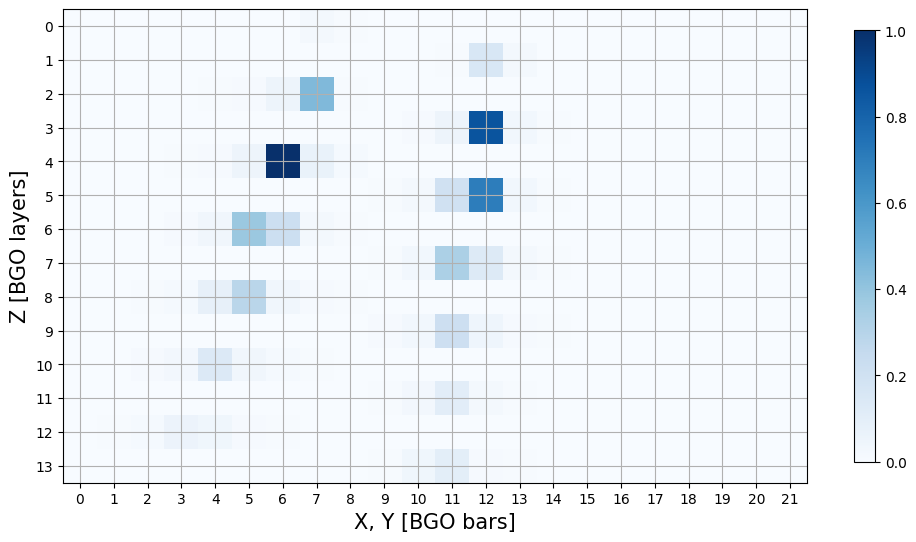

In [6]:
plot_image(calorimeter_images[0], savefig=True, figname = 'Shower_{}'.format(0))

Here we can see the structure of the data in image format for the first three showers.

The total energy of the shower and the max energy of a bar are also shown.

Note that there seem to be two lines alternating every row - this is the x-z and y-z split of the calormiter alternating each layer!

**The exercises can be found in the `README.md`**


Question : Is it starting with the x intercept or with the y intercept? Is the first row the x intercept and the second the y intercept or is it reversed?

(141946, 14, 22, 1)


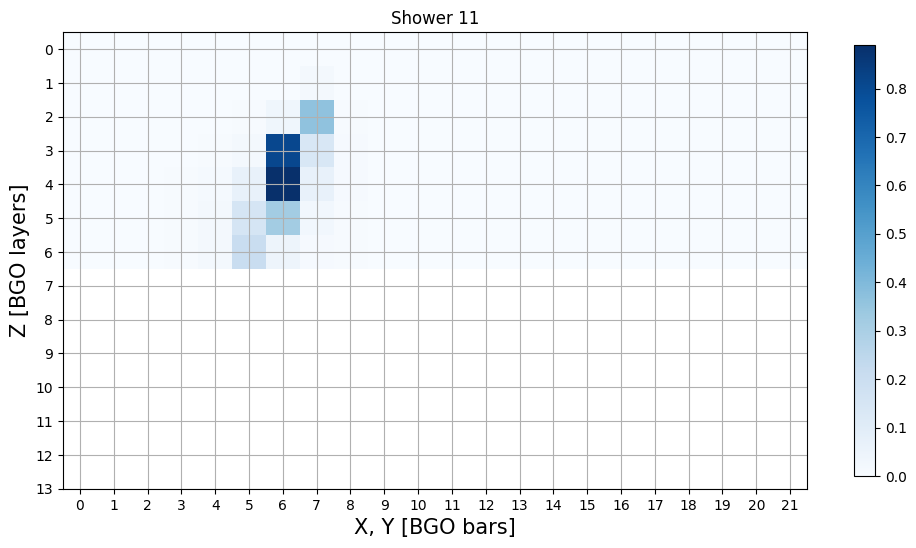

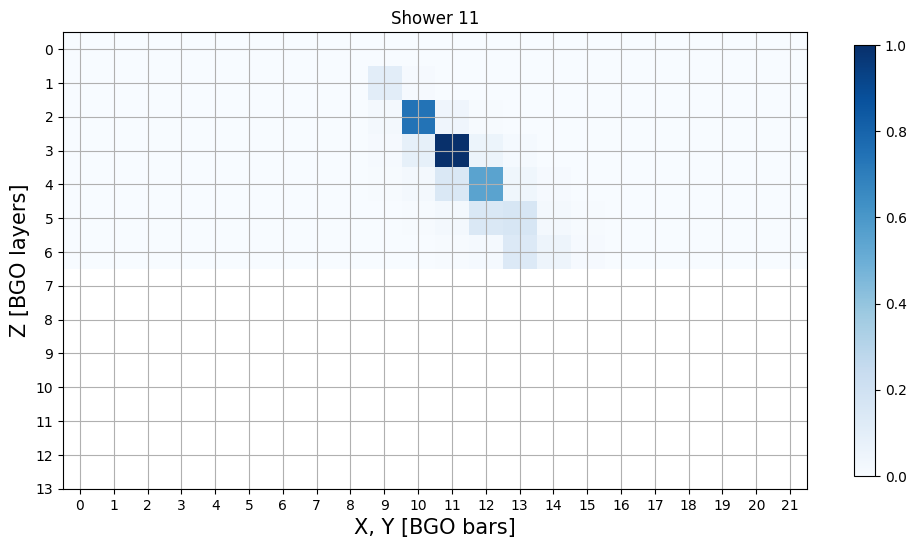

(<Figure size 1200x700 with 2 Axes>,
 <Axes: title={'center': 'Shower 11'}, xlabel='X, Y [BGO bars]', ylabel='Z [BGO layers]'>)

In [7]:
print(calorimeter_images.shape)
X, Y = split_xy_intercept(calorimeter_images)
plot_image(X[11], loglevel = True, image_name = 'Shower {}'.format(11))
plot_image(Y[11], image_name = 'Shower {}'.format(11))

Plot the image

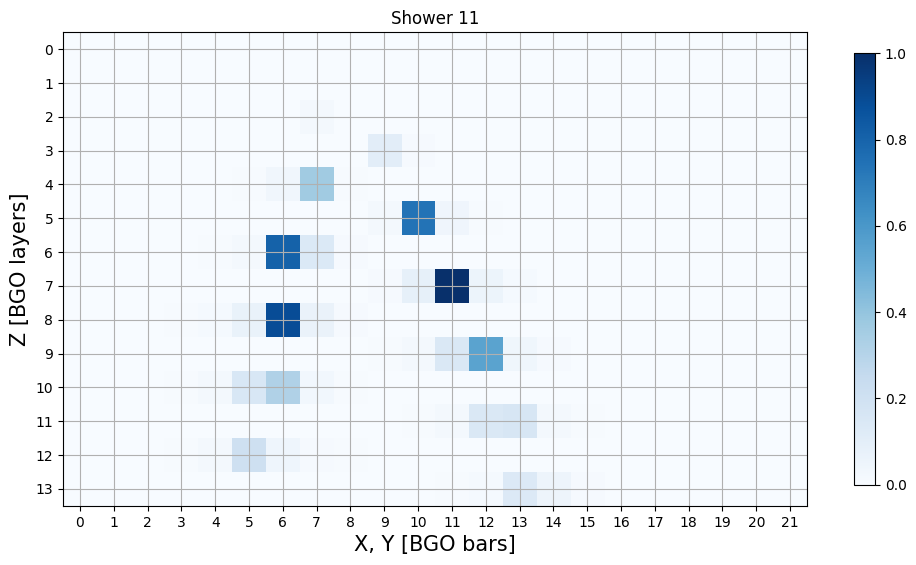

[18382280.   2695997.5]
[-173.23228  -106.88785   -33.886196  -64.71952 ]
[-173.8  -106.94  -38.3   -67.75]


In [8]:
shower_n = 11
plot_image(calorimeter_images[shower_n], image_name = 'Shower {}'.format(shower_n))

# Show the data first 
print(calorimeter_data[shower_n])
print(data_target[shower_n])
print(benchmark_data[shower_n])

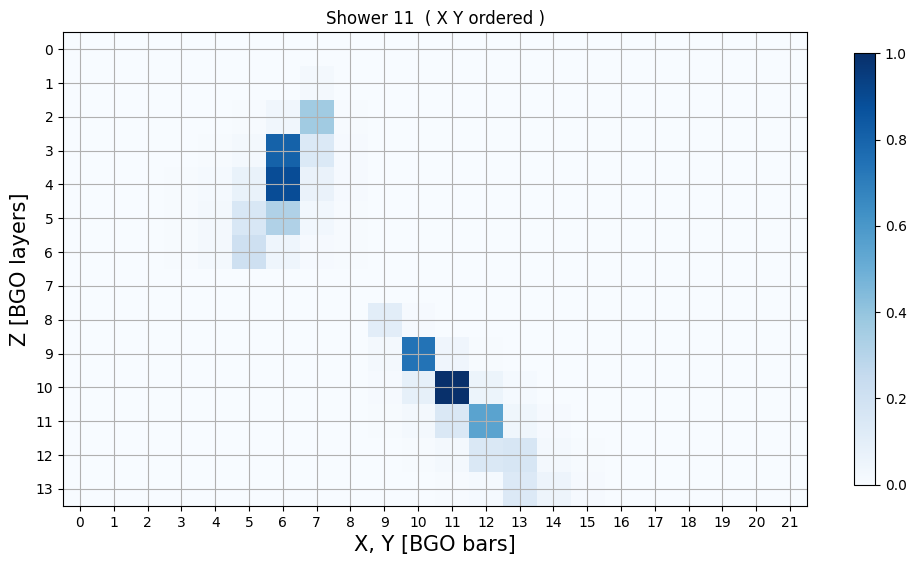

(<Figure size 1200x700 with 2 Axes>,
 <Axes: title={'center': 'Shower 11  ( X Y ordered )'}, xlabel='X, Y [BGO bars]', ylabel='Z [BGO layers]'>)

In [9]:
# Data process
XY = order_xy_intercept(calorimeter_images)
plot_image(XY[shower_n], loglevel = True, image_name = 'Shower {}  ( X Y ordered )'.format(11))

Without further processing we directly apply a convolutional neural network for the regression task.

We start by spliting in 3 sets : \
Test  \
Train \
Validation

In [10]:
# Normalize the data
# Split parameters
dampe_dic  = get_data_dict()
dampe_data = dampe_dic

Im_train, Im_val, Im_test, xy_train, xy_val, xy_test, energy_train, energy_val, energy_test = split_train_val_test(dampe_data = dampe_dic, val_size=val_size, test_size=test_size)

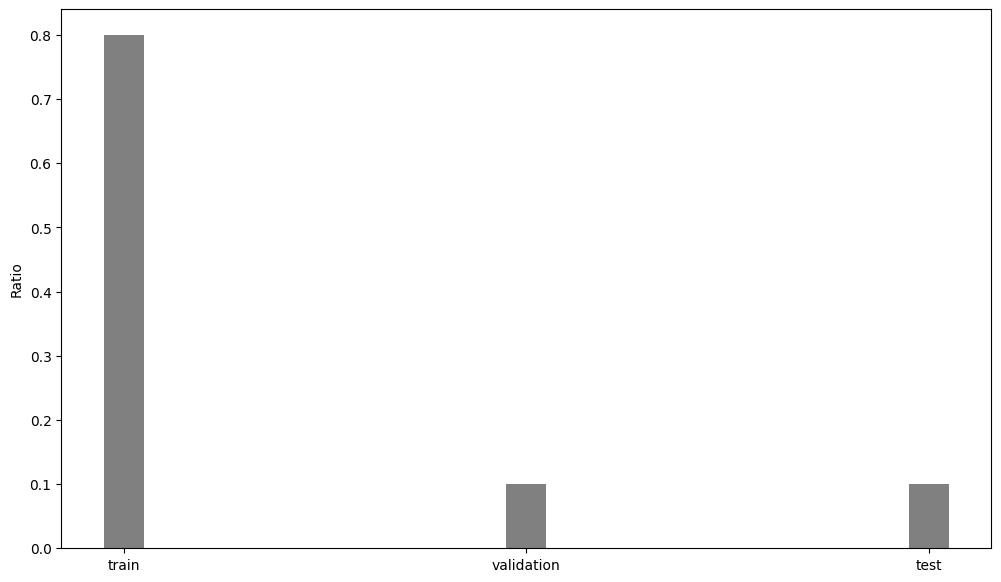

In [11]:
plot_split_distribution(dampe_dic, xy_train, xy_val, xy_test, figname='split_distribution.png');

In [12]:
if load_models:
    model_mix   = saving.load_model('./models/model_mix.keras')
    history_mix = helpers.load_model_history('./models/model_mix.json')
else:
    model_mix = calorimeter_model(dampe_dic, model_type = 4)
    # Compile and fit
    model_mix, history_mix = std_compile_fit(model_mix, [Im_train, energy_train], [Im_val, energy_val], [xy_train], [xy_val], epochs = epochs)
model_mix.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 calo_images (InputLayer)    [(None, 14, 22, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 10, 19, 32)           672       ['calo_images[0][0]']         
                                                                                                  
 conv2d_1 (Conv2D)           (None, 6, 16, 32)            20512     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 1, 1, 8)              24584     ['conv2d_1[0][0]']            
                                                                                              

In [13]:
if save_models: 
    save_model(model_mix, 'model_mix')
    save_model_history(history_mix, 'model_mix')   

In [14]:
bme = helpers.benchmarked_error(dampe_dic)

In [15]:
if load_models:
    model1   = saving.load_model('./models/model1.keras')
    history1 = helpers.load_model_history('./models/model1.json')
else:
    model1 = calorimeter_model(dampe_dic, model_type = 1)
    # Compile and fit
    model1, history1 = std_compile_fit(model1, Im_train, Im_val, xy_train, xy_val, epochs = epochs)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 10, 20, 52)        832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 10, 52)         0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 8, 42)          32802     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 4, 42)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 1, 32)          5408      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0

In [16]:
if save_models: 
    save_model(model1, 'model1')
    save_model_history(history1, 'model1')    

In [17]:
if load_models:
    model2   = keras.saving.load_model('./models/model2.keras')
    history2 = helpers.load_model_history('./models/model2.json')
else:
    model2 = calorimeter_model(dampe_dic, model_type = 2)
    # Compile and fit
    model2, history2 = std_compile_fit(model2, Im_train, Im_val, xy_train, xy_val, epochs = epochs)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 10, 19, 32)        672       
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 16, 32)         20512     
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 1, 8)           24584     
                                                                 
 flatten_2 (Flatten)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 64)                576       
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 46604 (182.05 KB)
Trainable params: 4660

In [18]:
if save_models: 
    save_model(model2, 'model2')
    save_model_history(history2, 'model2')    

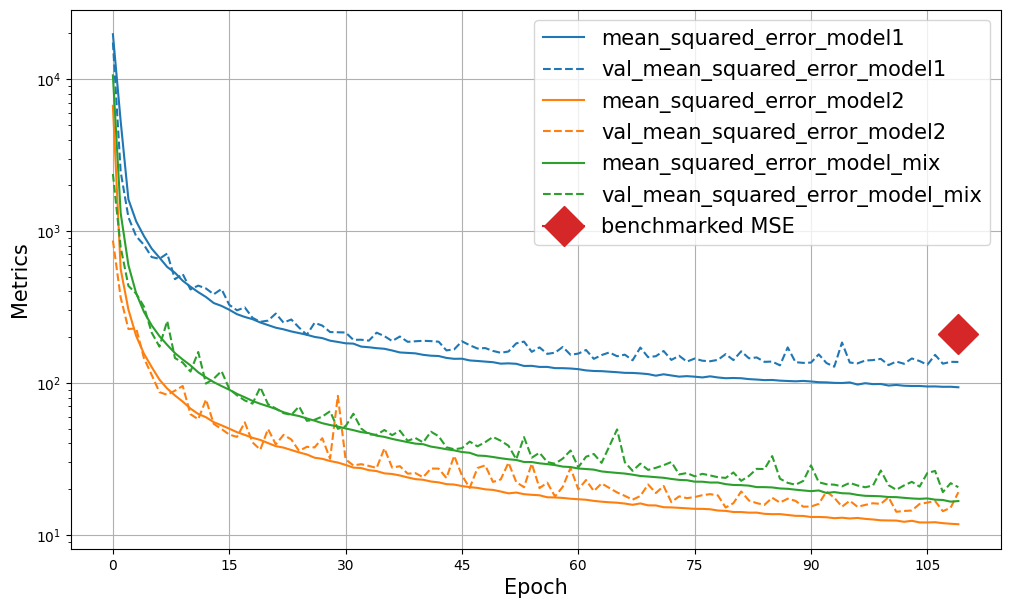

In [19]:
plot_model_history([history1,history2,history_mix],loglevel=True,savefig=True, figname='history12', label_str = ['_model1', '_model2','_model_mix'], bme = bme);

In [20]:
# Predict from the validation 
xy_prediction = model1.predict(Im_val)

444/444 [==============================] - 1s 2ms/step


Separate the energy levels

In [21]:
sorted_dic, sorted_idx = sort_data_by_energy('total')

In [22]:
split_dampe = split_dico(sorted_dic, frac=[0.5, 0.5])

In [23]:
# Split the data in train, validation and test
Im_train_low , Im_val_low , Im_test_low , xy_train_low , xy_val_low , xy_test_low, _, _ , _  = split_train_val_test(split_dampe[0], val_size = 0.2, test_size = 0.4)
Im_train_high, Im_val_high, Im_test_high, xy_train_high, xy_val_high, xy_test_high, _, _ , _ = split_train_val_test(split_dampe[1], val_size = 0.2, test_size = 0.4)

Build the splited model 

In [24]:
if load_models:
    model_low   = keras.saving.load_model('./models/model_low.keras')
    history_low = helpers.load_model_history('./models/model_low.json')
else:
    model_low = calorimeter_model(split_dampe[0], model_type = 3)
    # Compile and fit
    model_low, history_low = std_compile_fit(model_low, Im_train_low, Im_val_low, xy_train_low, xy_val_low, epochs = epochs)
model_low.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 10, 19, 8)         168       
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 16, 16)         2576      
                                                                 
 conv2d_11 (Conv2D)          (None, 1, 1, 16)          24592     
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                1088      
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 28684 (112.05 KB)
Trainable params: 2868

In [25]:
if save_models: 
    save_model(model_low, 'model_low')
    save_model_history(history_low, 'model_low')    

In [26]:
if load_models:
    model_high   = keras.saving.load_model('./models/model_high.keras')
    history_high = helpers.load_model_history('./models/model_high.json')
else:
    model_high = calorimeter_model(split_dampe[1], model_type = 3)
    model_high.summary()
    # Compile and fit
    model_high, history_high = std_compile_fit(model_high, Im_train_high, Im_val_high, xy_train_high, xy_val_high, epochs = epochs)

In [27]:
if save_models: 
    save_model(model_high, 'model_high')
    save_model_history(history_high, 'model_high')   

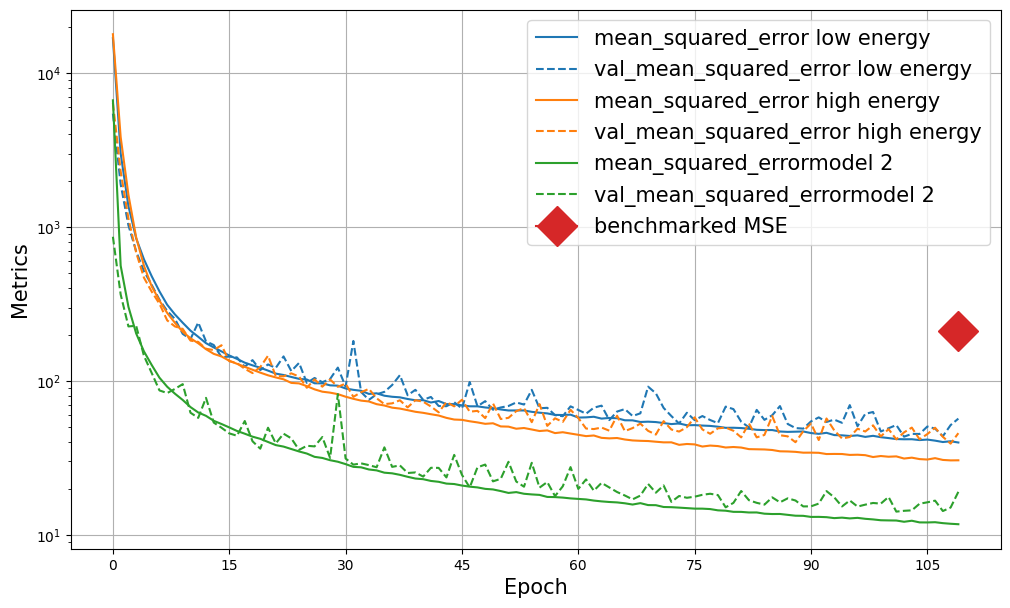

In [28]:
plot_model_history(
    [history_low,history_high,history2],
    loglevel=True, savefig=True,
    figname='history_split2',
    label_str=[' low energy', ' high energy', 'model 2'],
    bme=bme
);

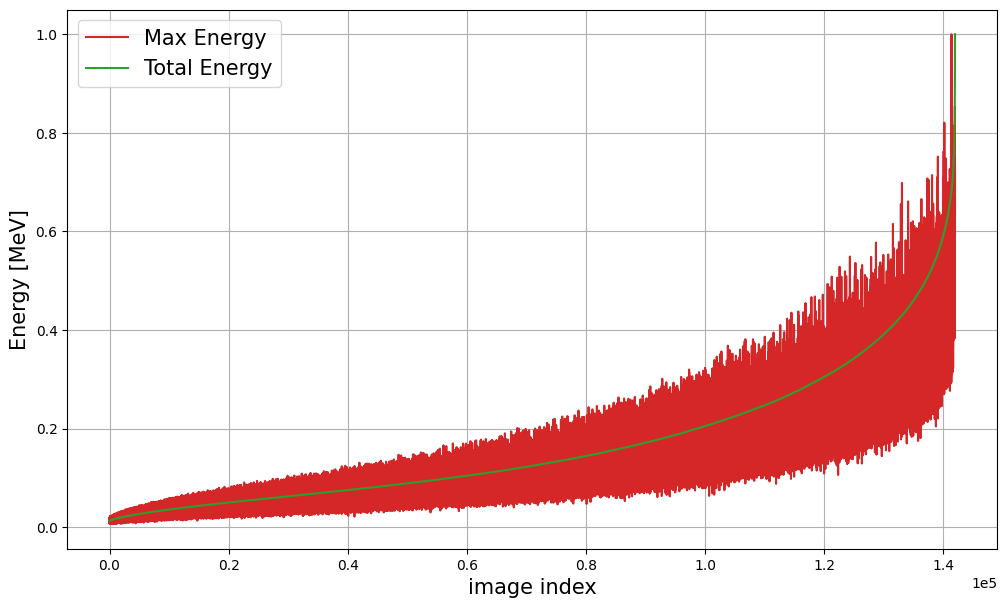

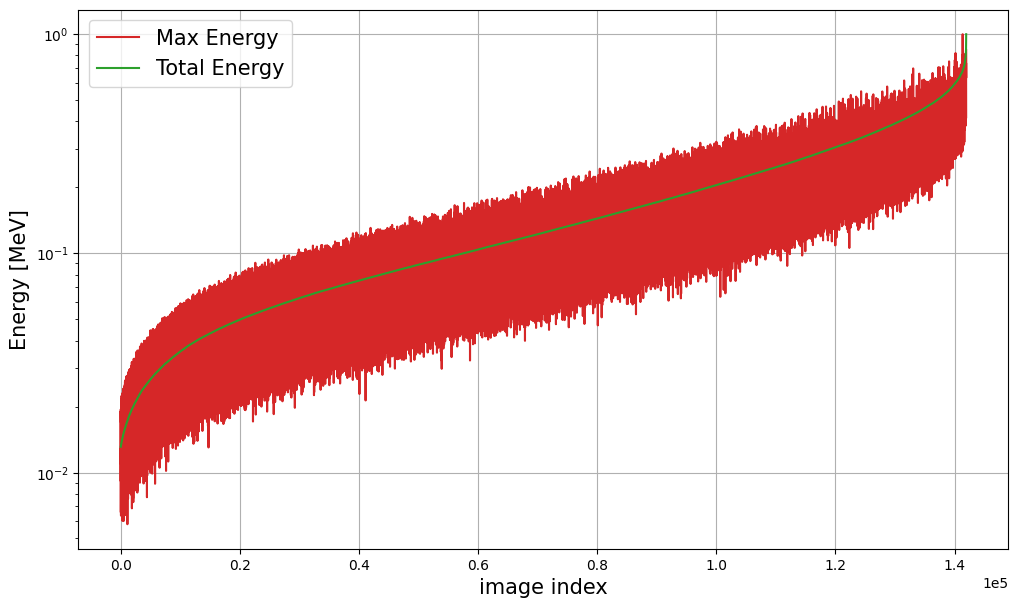

In [29]:
plot_energy(sorted_dic, loglevel=False, figname='energy.png');
plot_energy(sorted_dic, loglevel=True, figname ='energy_log.png');

#### Extra model with ordered data

In [ ]:
if load_models:
    model5   = keras.saving.load_model('./models/model5.keras')
    history5 = helpers.load_model_history('./models/model5.json')
else:
    # Transform the data to X and Y 
    dampe_orderedXY = dampe_dic.copy()
    dampe_orderedXY['images'] = order_xy_intercept(dampe_data['images'])
    Im_train, Im_val, Im_test, xy_train, xy_val, xy_test, _, _, _ = split_train_val_test(dampe_data = dampe_orderedXY, val_size=val_size, test_size=test_size)

    model5 = calorimeter_model(dampe_orderedXY, model_type = 5)
    model5.summary()
    # Compile and fit
    model5, history5 = std_compile_fit(model5, Im_train, Im_val, xy_train, xy_val, epochs = epochs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 20, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 16, 16)         12816     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 5, 16)          15376     
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 64)                20544     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [ ]:
if save_models: 
    save_model(model5, 'model5')
    save_model_history(history5, 'model5')   